<a href="https://colab.research.google.com/github/SDS-AAU/SDS-master/blob/master/M3/exercises/CNN_workshop_R.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
install.packages('reticulate')
install.packages('magrittr')

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [2]:
devtools::install_github("rstudio/keras") 

Skipping install of 'keras' from a github remote, the SHA1 (aaddf0e4) has not changed since last install.
  Use `force = TRUE` to force installation



In [3]:
library(tidyverse)
library(magrittr)
library(keras)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.4     ✔ dplyr   1.0.2
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.4.0     ✔ forcats 0.5.0

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


Attaching package: ‘magrittr’


The following object is masked from ‘package:purrr’:

    set_names


The following object is masked from ‘package:tidyr’:

    extract




In [39]:
# Let's start by downloading and exploring the data
temp <- tempfile()
download.file('https://storage.googleapis.com/sds-file-transfer/hot-dog-not-hot-dog.zip',temp)
unzip(temp)
unlink(temp)

In [41]:
list.files(path = "test") %>% head()
list.files(path = "train") %>% head()

[1] "hot_dog"     "not_hot_dog"

[1] "hot_dog"     "not_hot_dog"

# Preprocessing

Same as in the former notebook

In [42]:
# how much data?
train_size <- c(list.files(path = "train/hot_dog"), list.files(path = "train/not_hot_dog")) %>% length()
test_size <- c(list.files(path = "test/hot_dog"), list.files(path = "test/not_hot_dog")) %>% length()

In [43]:
class_list <- c('hot_dog', 'not_hot_dog')
output_n <- length(class_list)
img_width <- 224
img_height <- 224
target_size <- c(img_width, img_height)
channels <- 3
train_files_path <- 'train'
test_files_path <- 'test'
batch_size <- 32

In [44]:
train_data_gen = image_data_generator(rescale = 1/255, shear_range = 0.2, zoom_range = 0.2, horizontal_flip = TRUE)
test_data_gen <- image_data_generator(rescale = 1/255)  

In [45]:
train_image_array_gen <- flow_images_from_directory(train_files_path, train_data_gen, target_size = target_size, class_mode = "binary", 
                                                    classes = class_list,batch_size = batch_size, seed = 1337)

test_image_array_gen <- flow_images_from_directory(test_files_path, test_data_gen, target_size = target_size, class_mode = "binary",
                                          classes = class_list, batch_size = batch_size, seed = 1337)

# Loading pretrained model

Keras has some great built-in applications - basically pretrained models with some nice functional overhead. We will start by loadeing VGG16 (a rather large model with many many many layers that has been trained on imagenet)



In [46]:
# create the base pre-trained model
base_model <- application_vgg16(
  include_top = FALSE,
  weights='imagenet',
  input_shape = c(img_height, img_width, channels))

In [48]:
predictions <- base_model$output %>% 
  layer_flatten(trainable = T) %>%
  layer_dense(1024, activation = 'relu', trainable = T) %>%
  layer_dropout(0.4, trainable = T) %>%
  layer_dense(84, activation = 'relu', trainable=T) %>%  
  layer_dense(units = 1, activation = 'sigmoid', trainable=T)

In [49]:
# this is the model we will train
model <- keras_model(inputs = base_model$input, outputs = predictions)

In [ ]:
# let's visualize layer names and layer indices to see how many layers we should freeze:
layers <- base_model$layers
for (i in 1:length(layers))
  cat(i, layers[[i]]$name, "\n")

In [50]:
# first: train only the top layers 
for (layer in base_model$layers)
  layer$trainable <- FALSE

In [51]:
# compile the model (should be done *after* setting layers to non-trainable)
model %>% compile(optimizer = 'adam', 
                  loss = 'binary_crossentropy',
                  metric = 'accuracy')

In [52]:
# train the model on the new data for a few epochs
model %>% fit_generator(
  train_image_array_gen,
  steps_per_epoch = as.integer((train_size / batch_size) ),
  epochs = 5, 
  verbose = FALSE,
  )

In [54]:
# we chose to train the top 2 blocks, i.e. we will freeze the first layers and unfreeze the rest:
for (i in 1:17)
  layers[[i]]$trainable <- FALSE
for (i in 18:length(layers))
  layers[[i]]$trainable <- TRUE

In [55]:
# we need to recompile the model for these modifications to take effect
model %>% compile(optimizer = 'adam', 
                  loss = 'binary_crossentropy',
                  metric = 'accuracy')

In [56]:
# we train our model again (this time fine-tuning the top 2  blocks
# alongside the top Dense layers
# train the model on the new data for a few epochs
hist <- model %>% fit_generator(
  train_image_array_gen,
  steps_per_epoch = as.integer((train_size / batch_size) ),
  epochs = 10, 
  validation_data = test_image_array_gen,
  validation_steps = as.integer((test_size / batch_size) ),
  verbose = FALSE
  )

`geom_smooth()` using formula 'y ~ x'



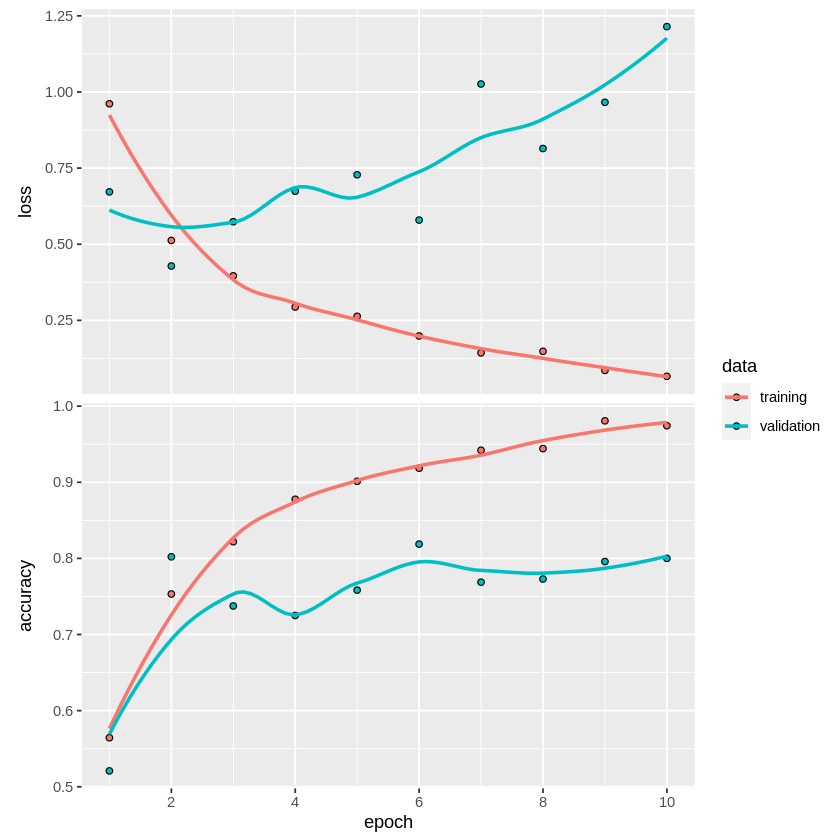

In [57]:
hist %>% plot()

In [58]:
model %>% evaluate_generator(test_image_array_gen, steps=500)

loss accuracy 
1.191823 0.800000

# some own image

![](https://do512family.com/wp-content/uploads/2018/04/18222376_1528395153845930_2934228273602805559_n.jpg)


![](http://myminidoxie.com/wp-content/uploads/2012/11/which-came-first-the-wiener-or-the-dachshund.jpg)


In [59]:
download.file('https://do512family.com/wp-content/uploads/2018/04/18222376_1528395153845930_2934228273602805559_n.jpg',
'wiener1.jpg', mode = 'wb')

download.file('http://myminidoxie.com/wp-content/uploads/2012/11/which-came-first-the-wiener-or-the-dachshund.jpg',
'wiener2.jpg', mode = 'wb')

In [63]:
img <- image_load('wiener2.jpg', target_size = target_size) %>% image_to_array() %>% array_reshape(c(1, dim(.)))

In [64]:
res <- predict(model, img)

In [65]:
ifelse(res == 0, 'hot_dog', 'not_hot_dog')

not_hot_dog


# Model explanations